### Integrated QLC + Vapor Field

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from matplotlib import rcParams

# QLC-specific code
import QLCstuff as QLC; reload(QLC)

<module 'QLCstuff' from '/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py'>

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 2
fontsize = 15
color = 'k'
markersize = 10

### Defining system and run parameters

In [3]:
# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

# Temperature
Temperature = AssignQuantity(245,'kelvin')
print('Temperature =',Temperature)

# Ambient pressure
Pressure = AssignQuantity(50,'pascal')
print('Pressure =', Pressure)

# Size of the box
L = AssignQuantity(30,'micrometer')

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.24
print('sigmaI, far field =',sigmaI_far_field)

# Kinetic velocity
Iwantcalculated_nu_kin = True
if Iwantcalculated_nu_kin:
    print('Calculating a kinetic velocity')
    nu_kin = QLC.get_nu_kin(Temperature,AssignQuantity)
    print('   nu_kin = ',nu_kin)
else:
    print('Assigning a kinetic velocity')
    nu_kin = AssignQuantity(34,'micrometer/second')
    print('   nu_kin = ',nu_kin)
nu_kin_mag = nu_kin.magnitude
nmpermonolayer = AssignQuantity(0.3,'nanometer')
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)
nu_kin_mlyperus = (nu_kin/umpersec_over_mlyperus).magnitude # monolayers per microsecond
print('   nu_kin_mlyperus =', nu_kin_mlyperus, 'old method, monolayers per microsecond')
nu_kin_mlyperus = nu_kin/nmpermonolayer
nu_kin_mlyperus.ito('1/microsecond')
print('   nu_kin_mlyperus =', nu_kin_mlyperus)
# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')
    
# Surface diffusion coefficient
Iwantcalculated_D = True
if Iwantcalculated_D:
    print('Calculating the surface diffusion coefficient')
    D = QLC.get_D_of_T(Temperature,AssignQuantity)
    print('   D = ',D)
else:
    print('Assigning a surface diffusion coefficient')
    D = AssignQuantity(1e-3,'micrometers^2/microsecond')
    print('   D = ',D)
D_mag = D.magnitude

# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)

Temperature = 245 kelvin
Pressure = 50 pascal
sigma0 = 0.2
sigmaI, far field = 0.24
Calculating a kinetic velocity
   nu_kin =  64.93378950063328 micrometer / second
   nu_kin_mlyperus = 0.21644596500211094 old method, monolayers per microsecond
   nu_kin_mlyperus = 0.21644596500211088 / microsecond
Calculating the surface diffusion coefficient
   D =  0.0002914301893895377 micrometer ** 2 / microsecond


### Testing the vaporfield simulation code

In [4]:
# Growth rate of the crystal
g_ice_vapor = AssignQuantity(2.0,'micrometer/second')
print('g_ice_vapor = ',g_ice_vapor)

# Integraton method
Integration_method = 'Euler'

# Call the vaporfield code
tmax = AssignQuantity(10,'microsecond')
[x_vapor, sigmaIx_vapor], [y_vapor, sigmaIy_vapor] = \
    QLC.VF2d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,L,\
             AssignQuantity,verbose=0,Integration_method=Integration_method,tmax=tmax)

g_ice_vapor =  2.0 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>


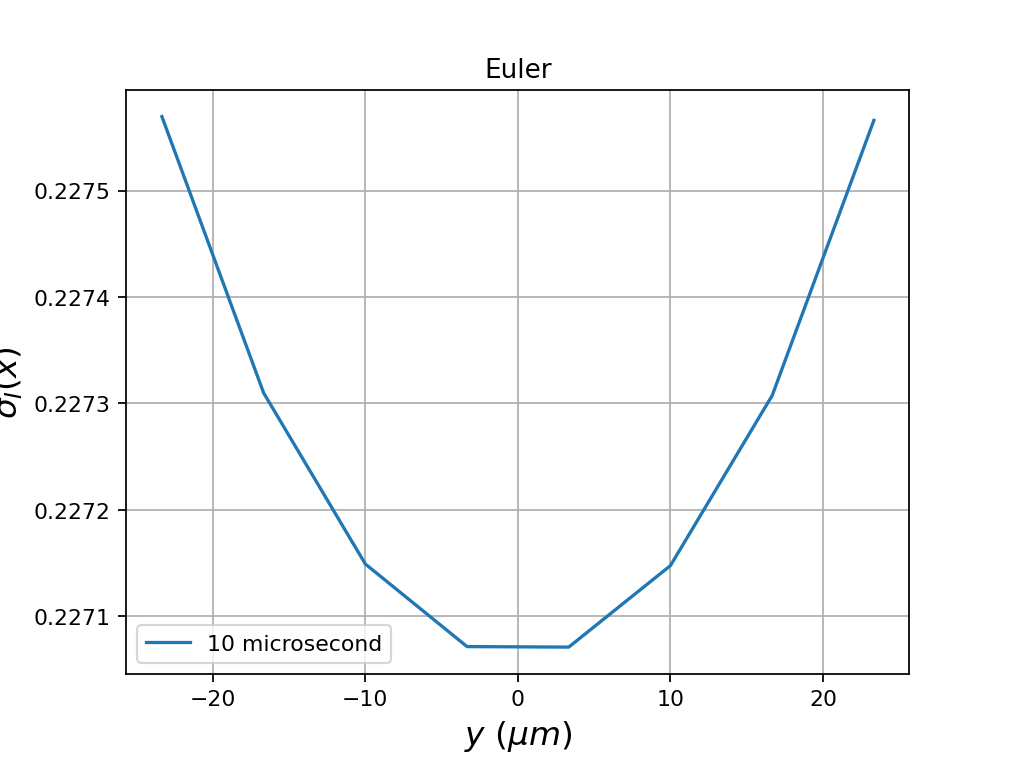

In [5]:
# Plot it
plt.figure()        
plt.plot(x_vapor.magnitude,sigmaIx_vapor.magnitude,label=str(tmax),ms=markersize)
plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x)$',fontsize=fontsize)
plt.title(Integration_method)
plt.grid(True)
plt.legend()

### Map the vapor field at the surface coming from the vaporfield simulation onto the QLC space

<IPython.core.display.Javascript object>


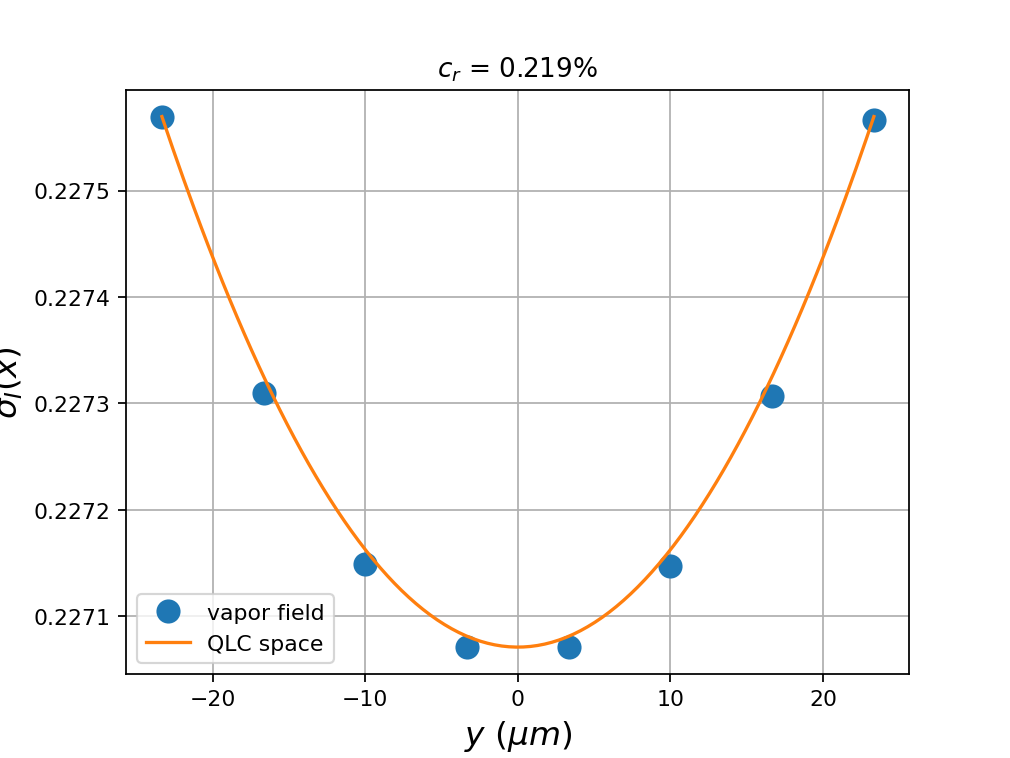

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


In [6]:
import QLCstuff as QLC; reload(QLC)
# What's the center reduction?
c_r = (np.max(sigmaIx_vapor)-np.min(sigmaIx_vapor))/np.max(sigmaIx_vapor)
c_r_percent = c_r*100

# Estimate the number of x-points for consistency between runs
Lx_reference = AssignQuantity(75,'micrometer')
nx = int(501*L/Lx_reference)

# Lay out the x-array
x_QLC = np.linspace(x_vapor[0],x_vapor[-1],nx)
deltax = x_QLC[1]-x_QLC[0]
Doverdeltax2 = D/deltax**2

# We'll use sigmaIx for sigmaI
sigmaI_QLC = np.interp(x_QLC,x_vapor,sigmaIx_vapor)

# But adjusting it because the vaporfield code isn't symmetrical
Iwantparabolic = True
if Iwantparabolic:
    alpha = c_r*np.max(sigmaIx_vapor)/x_vapor[-1]**2
    sigmaI_QLC = alpha*x_QLC**2+np.min(sigmaIx_vapor)

# Symmetrizing no matter what
ix_QLC_mid = int(len(x_QLC)/2)
for i in range(0,ix_QLC_mid):
    sigmaI_QLC[-i-1] = sigmaI_QLC[i]

# Making sure the interpolation went well
plt.figure()        
plt.plot(x_vapor.magnitude,sigmaIx_vapor.magnitude,'o',label='vapor field',ms=markersize)
plt.plot(x_QLC.magnitude,sigmaI_QLC,label='QLC space',ms=markersize)
plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x)$',fontsize=fontsize)
title = r"$c_r$ = " + "{:.3f}".format(c_r_percent.magnitude)+'%'
plt.title(title)
plt.grid(True)
plt.legend()

In [7]:
sigmaI_QLC[0]-sigmaI_QLC[-1]

0.0 <Unit('dimensionless')>

### Testing the QLC code

Estimating times for the trajectory run
   time (est) =  352.92794165981064 millisecond
   time (used) =  352.92794165981064 millisecond
   dt = 3564.9287036344513 microsecond
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


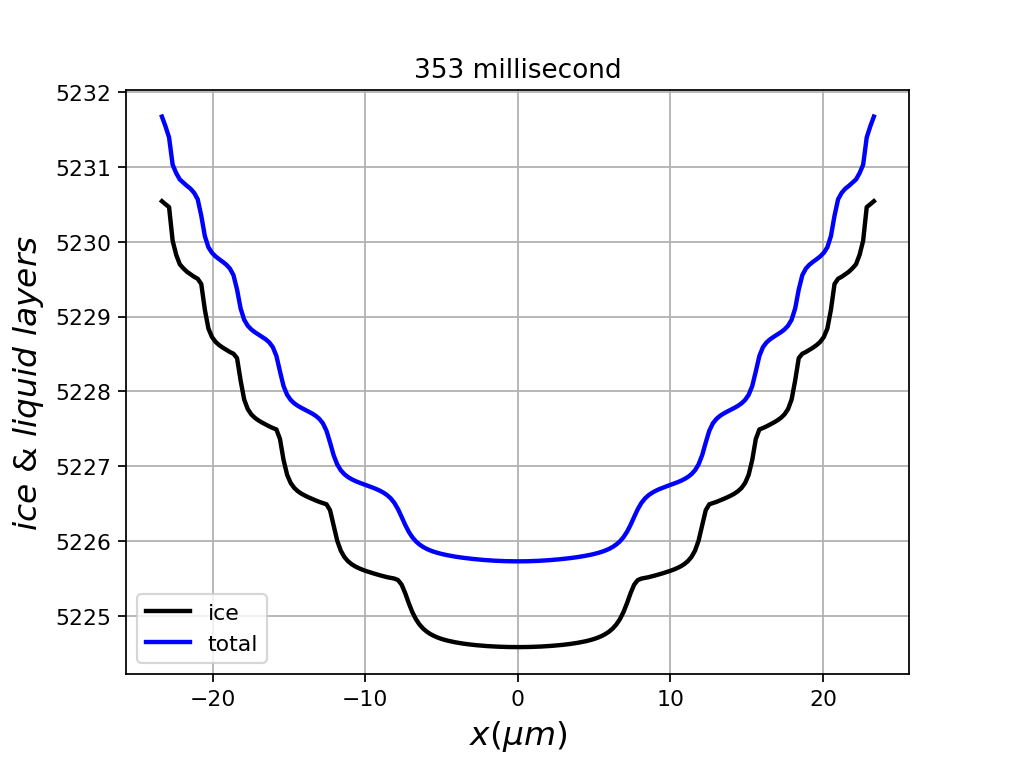

<IPython.core.display.Javascript object>


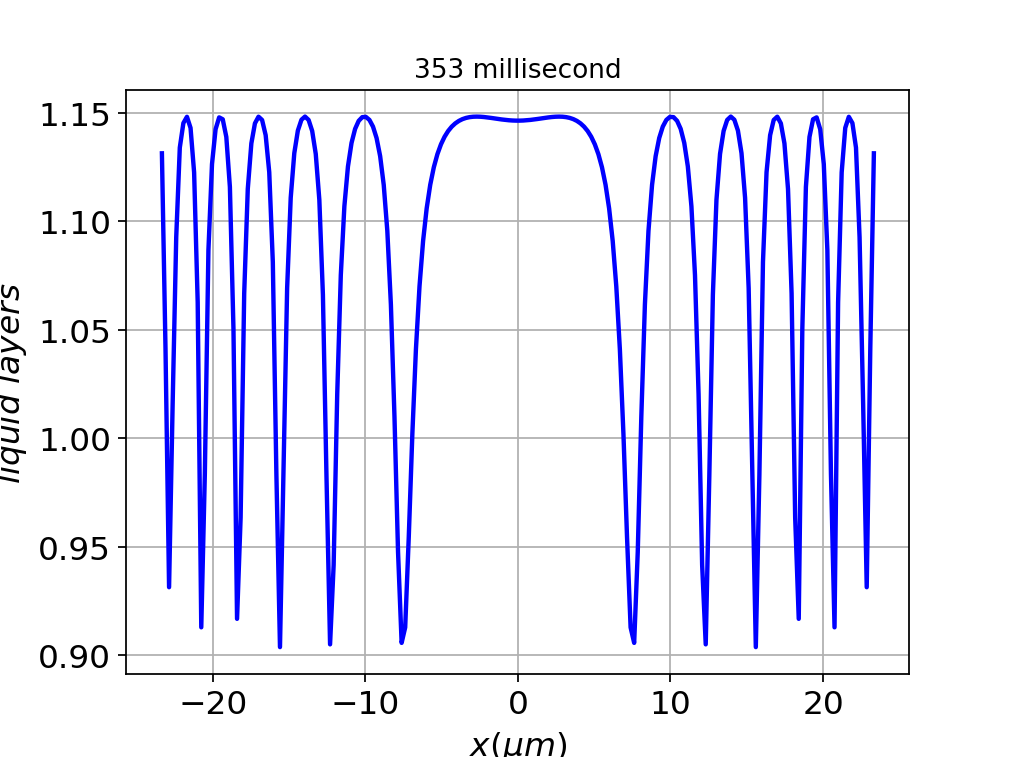

<IPython.core.display.Javascript object>


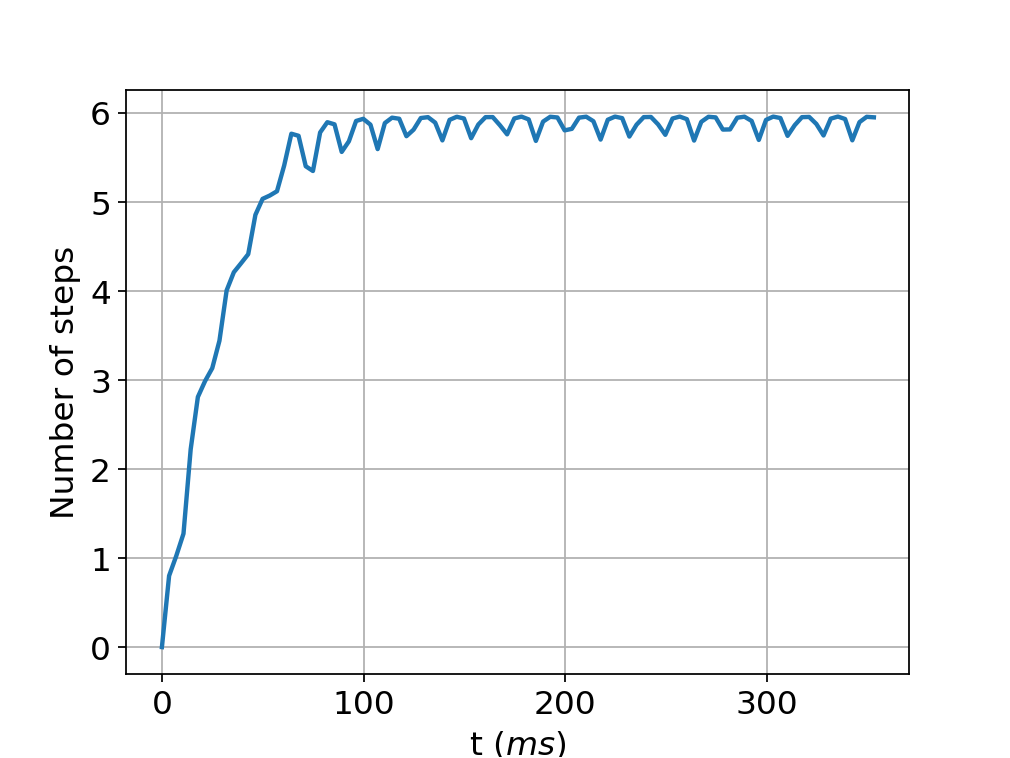

growth rates ... 
   from previous vaporfield =  2.0 micrometer / second
   from QLC =  4.441821517600122 micrometer / second


In [8]:
# Estimating/deciding on how long to make the integration
print('Estimating times for the trajectory run')
L_reference = AssignQuantity(1,'millimeter')
time_reference = AssignQuantity(1,'millisecond')
tlast_estimated = (L*L_reference/D*time_reference)**.5*1.1
tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)
tlast = tlast_msec.to('microsecond')

# Number of time steps to report back
ntimes = 100
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Solve
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                AssignQuantity,\
                verbose=0, odemethod='LSODA')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Report
g_ice_QLC = QLC.report_growth_results(x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer)
print('growth rates ... ')
print('   from previous vaporfield = ',g_ice_vapor)
print('   from QLC = ',g_ice_QLC)

### Now the self-consistency loop

g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>


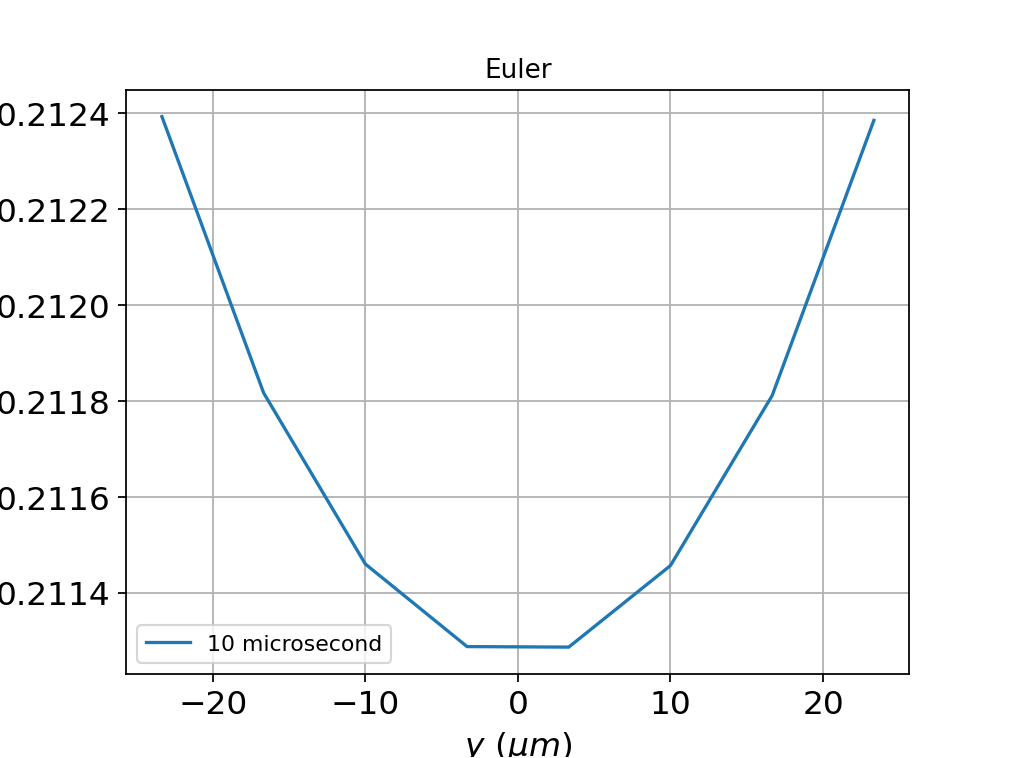

From vapor simulation ... 
c_r = 0.521%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


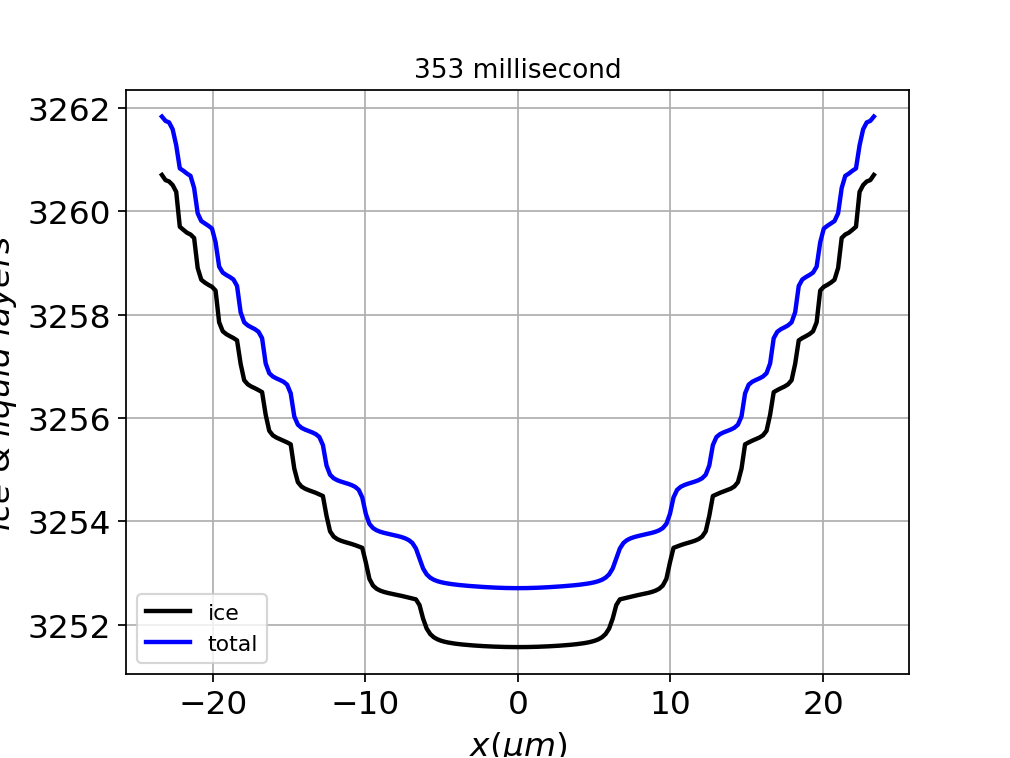

<IPython.core.display.Javascript object>


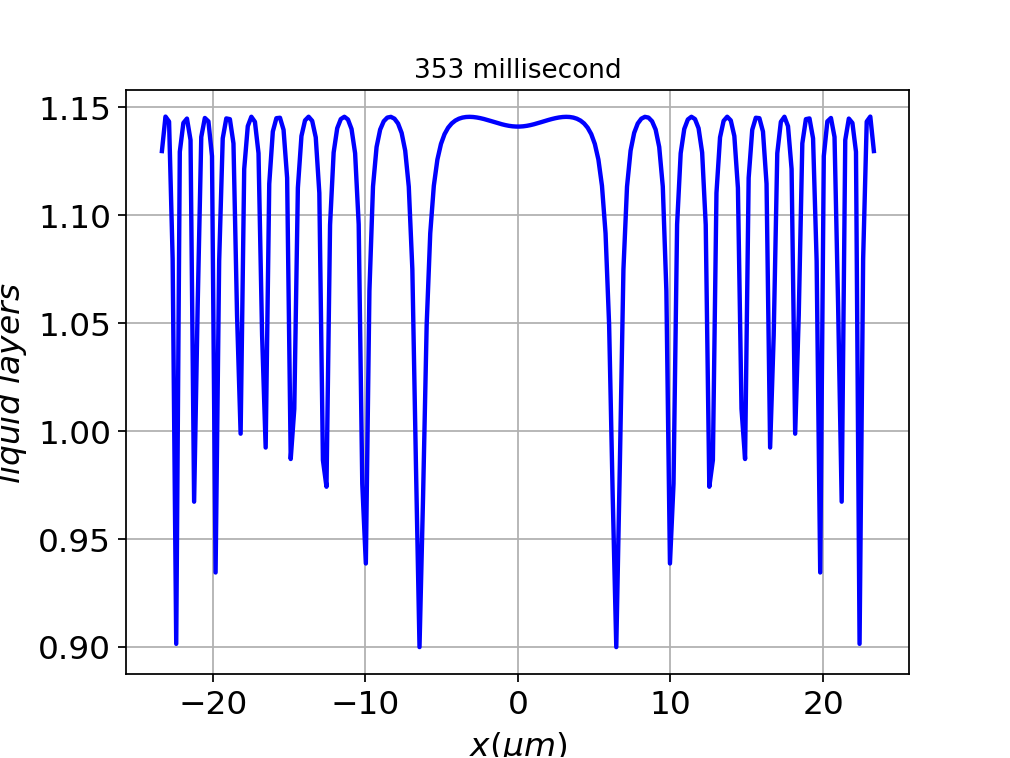

<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  4.441821517600122 micrometer / second
   from QLC =  2.7629072222658757 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.309%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


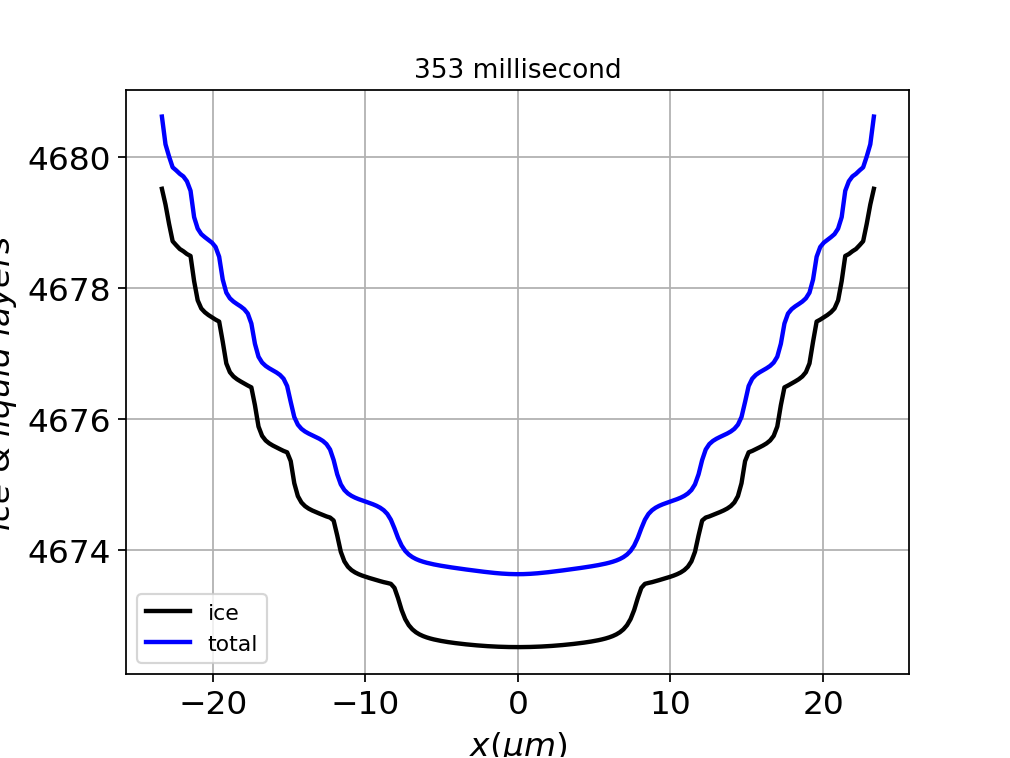

<IPython.core.display.Javascript object>


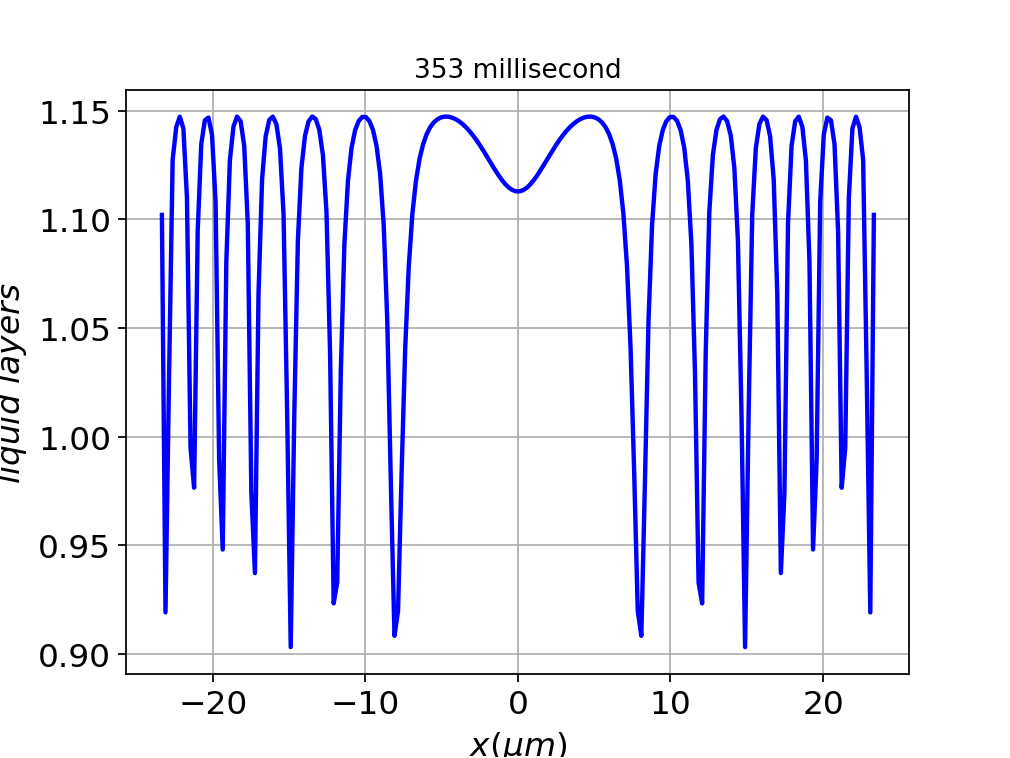

<IPython.core.display.Javascript object>


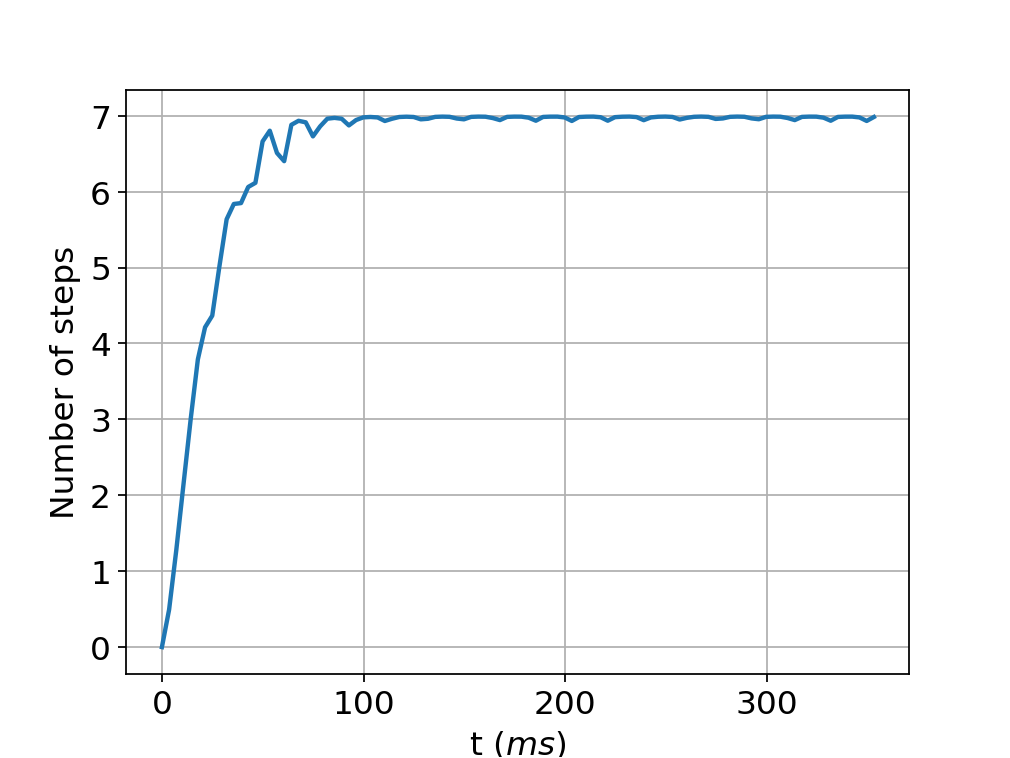

growth rates ... 
   from previous vaporfield =  2.7629072222658757 micrometer / second
   from QLC =  3.972196014315168 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.460%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


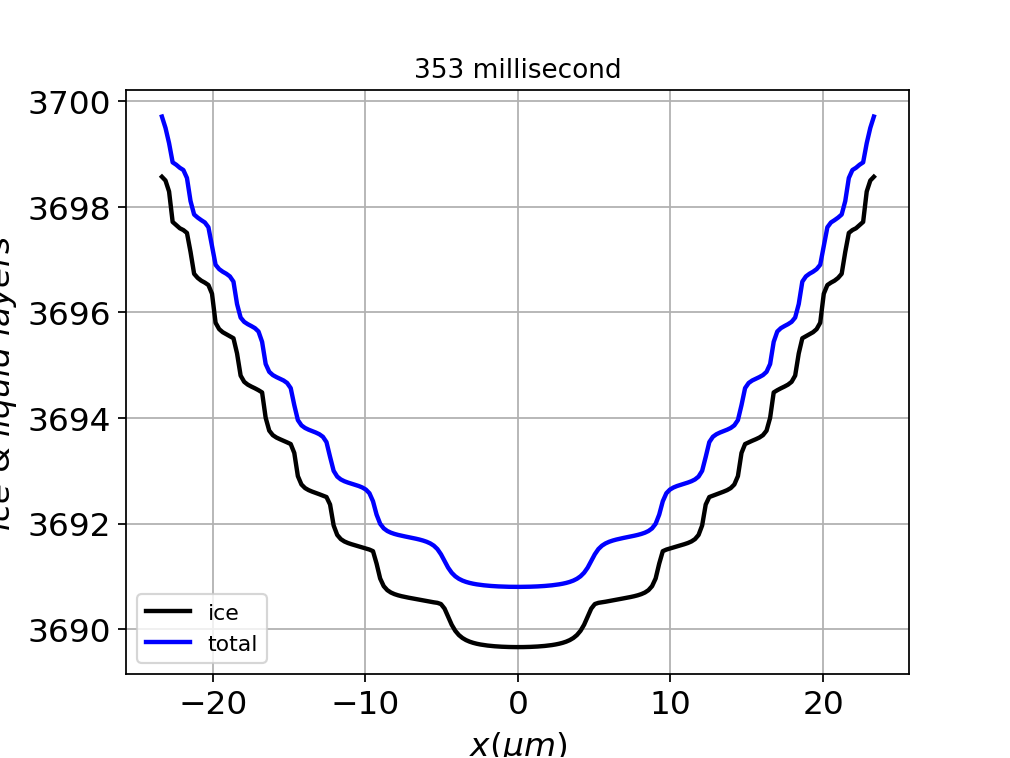

<IPython.core.display.Javascript object>


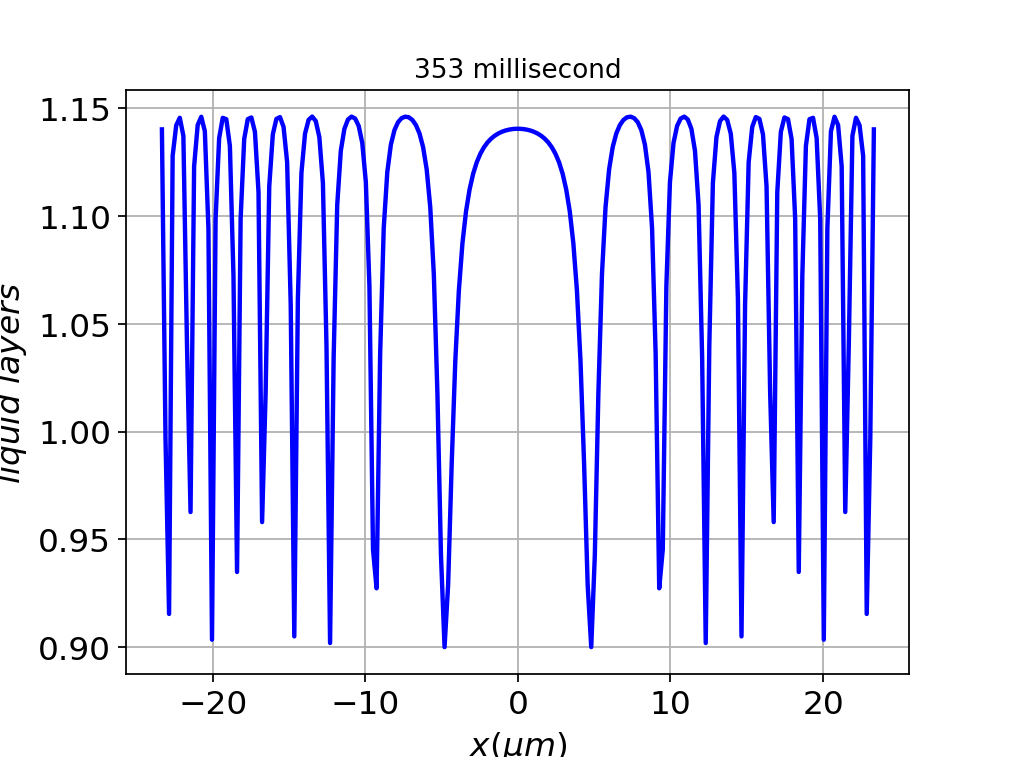

<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  3.972196014315168 micrometer / second
   from QLC =  3.1367478320461633 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.354%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py:565: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  3.1367478320461633 micrometer / second
   from QLC =  3.726709406433535 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.428%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


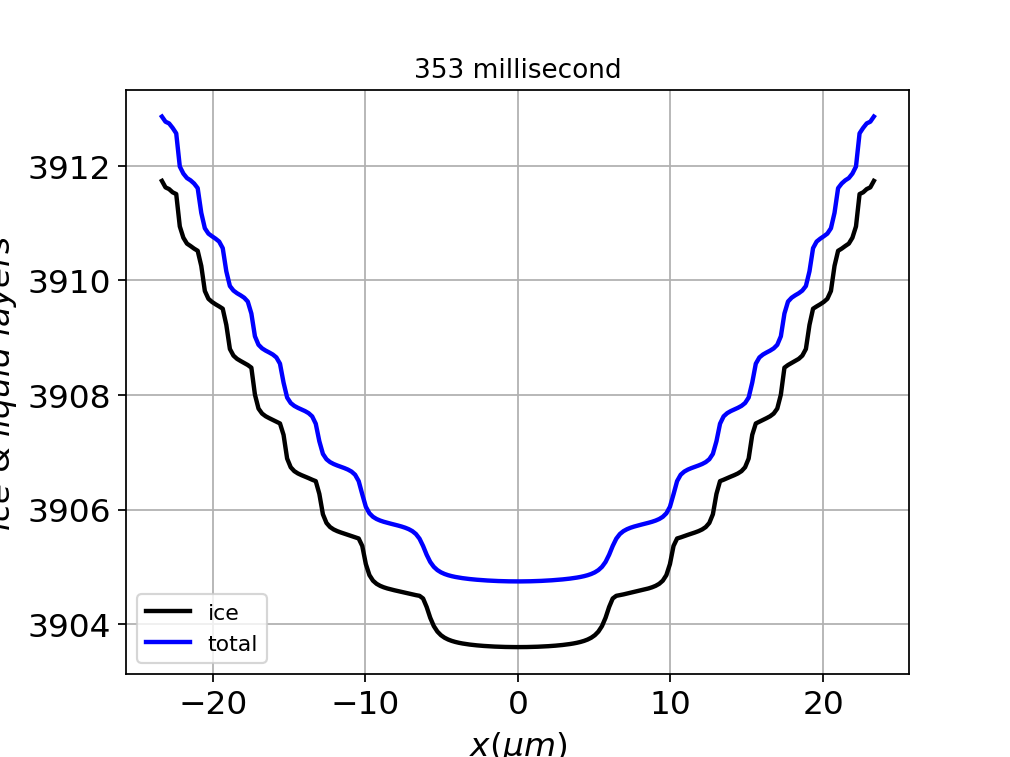

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


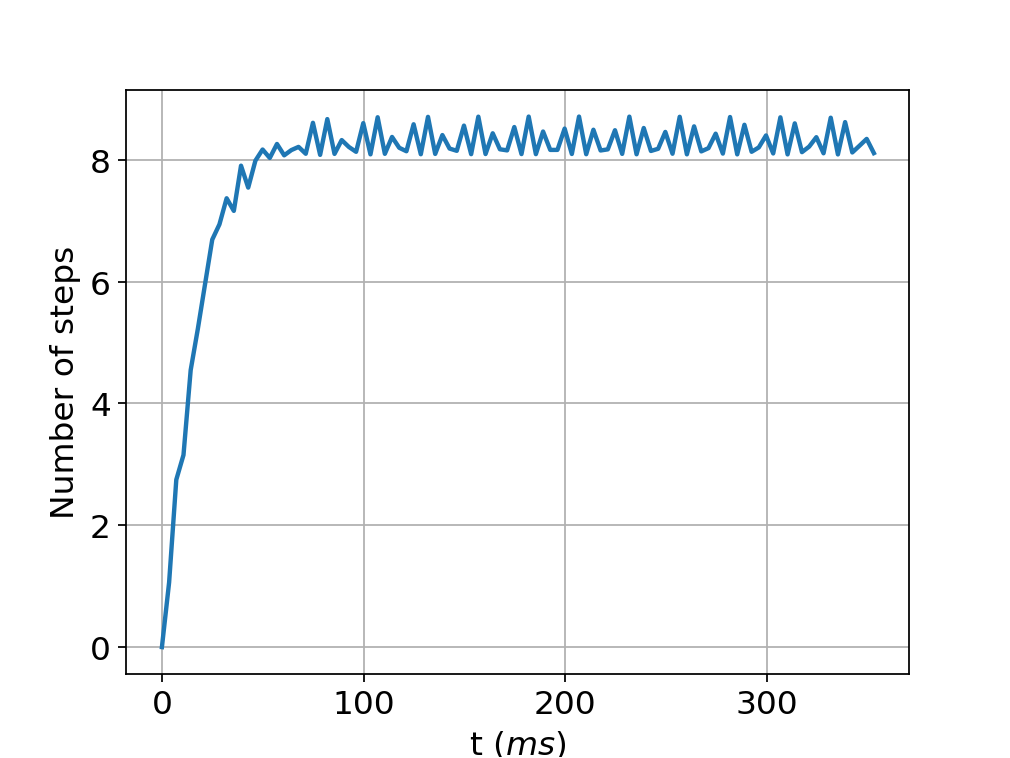

growth rates ... 
   from previous vaporfield =  3.726709406433535 micrometer / second
   from QLC =  3.317260621171848 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>


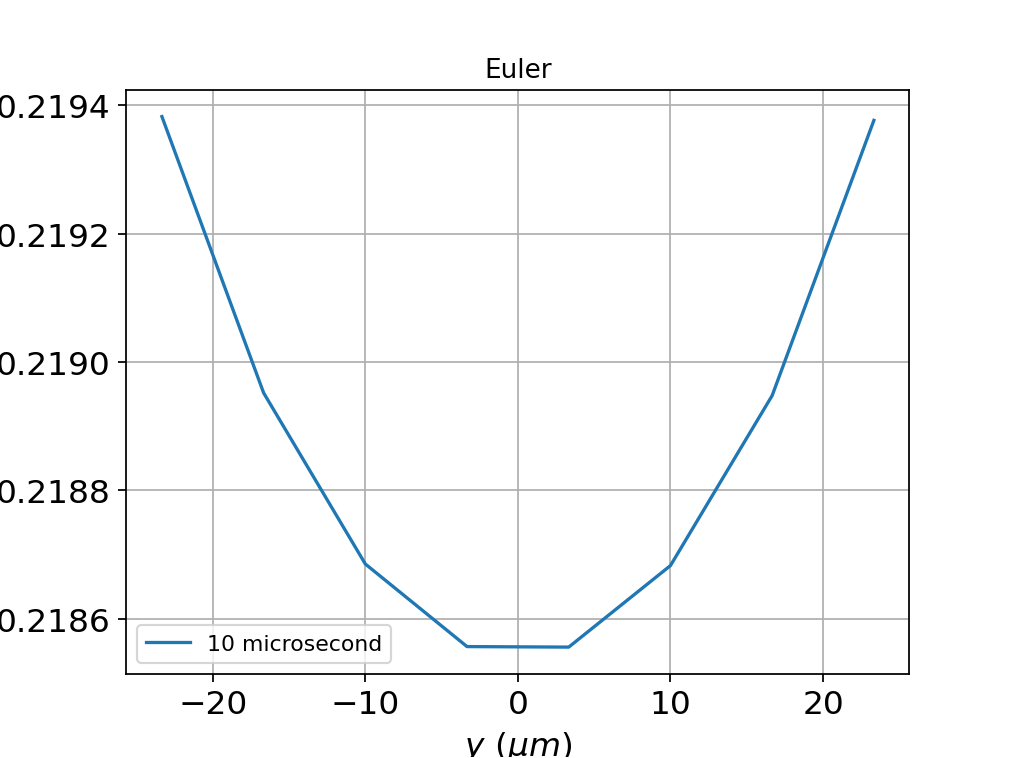

From vapor simulation ... 
c_r = 0.377%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


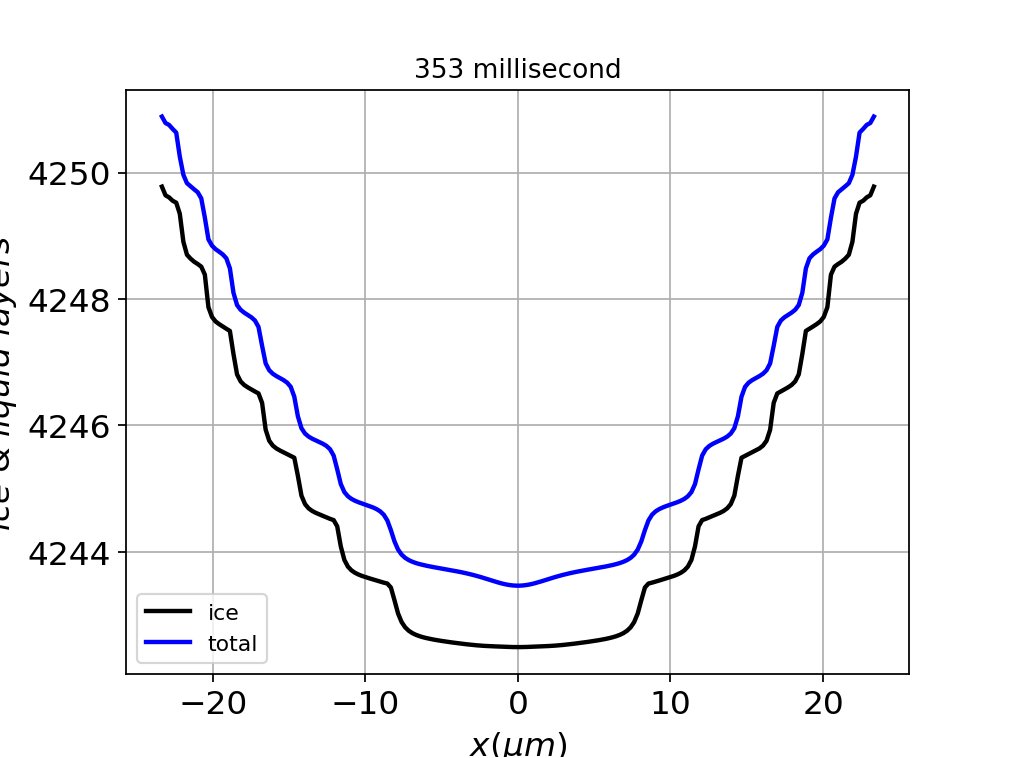

<IPython.core.display.Javascript object>


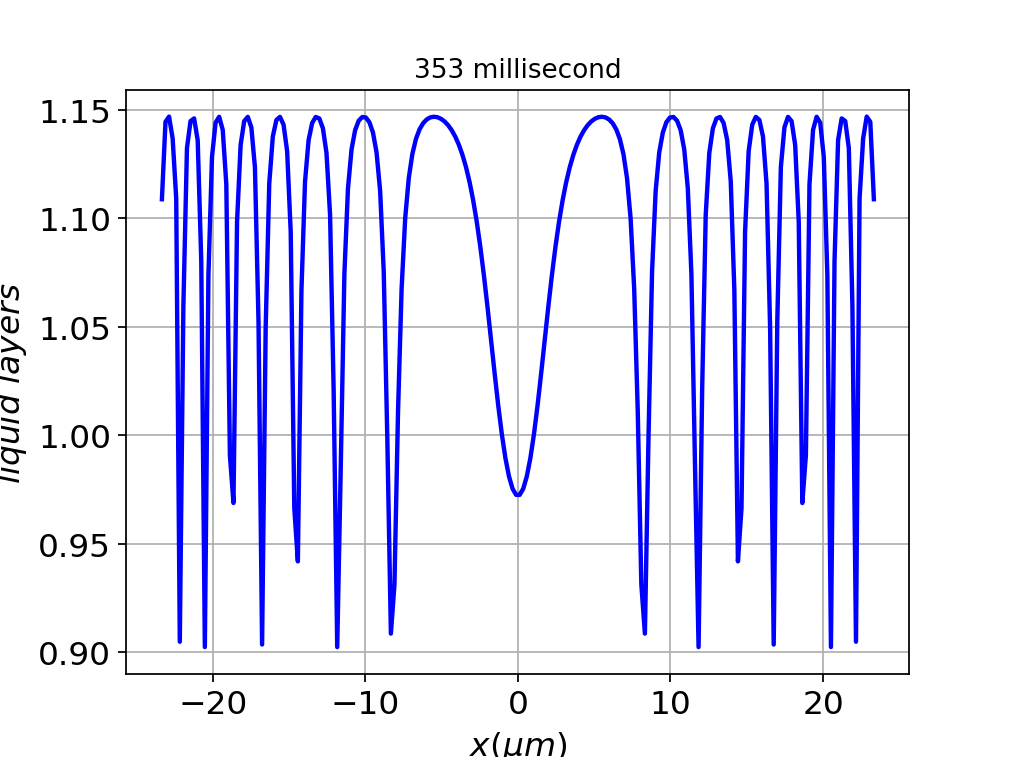

<IPython.core.display.Javascript object>


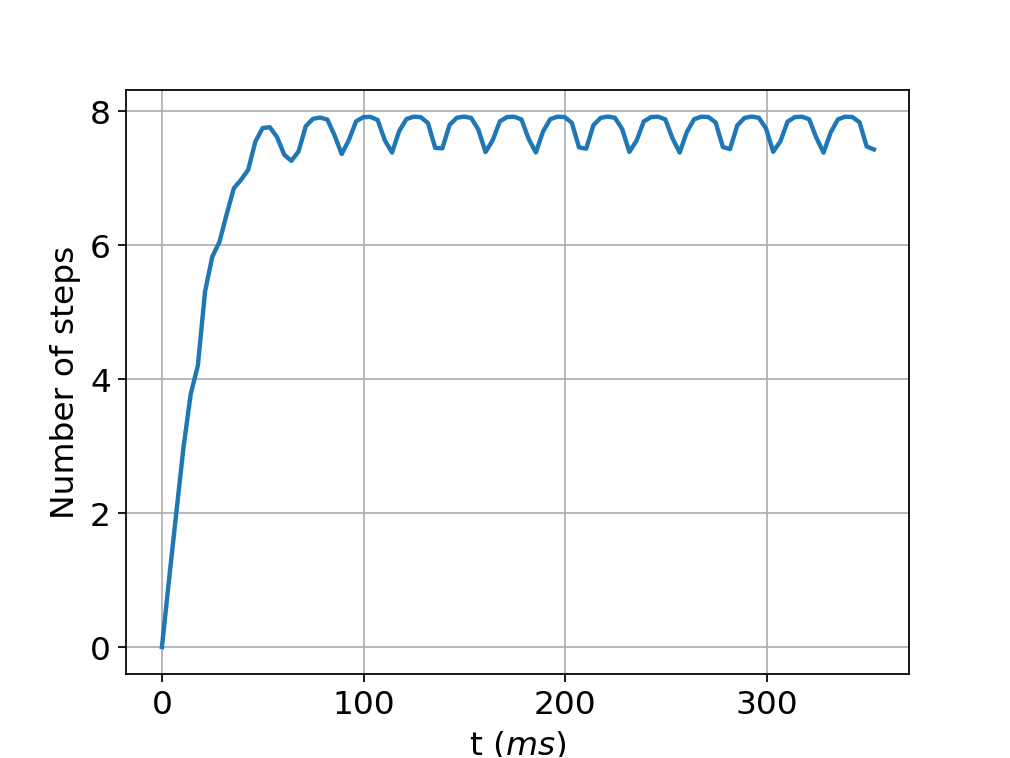

growth rates ... 
   from previous vaporfield =  3.317260621171848 micrometer / second
   from QLC =  3.6048911184337653 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>


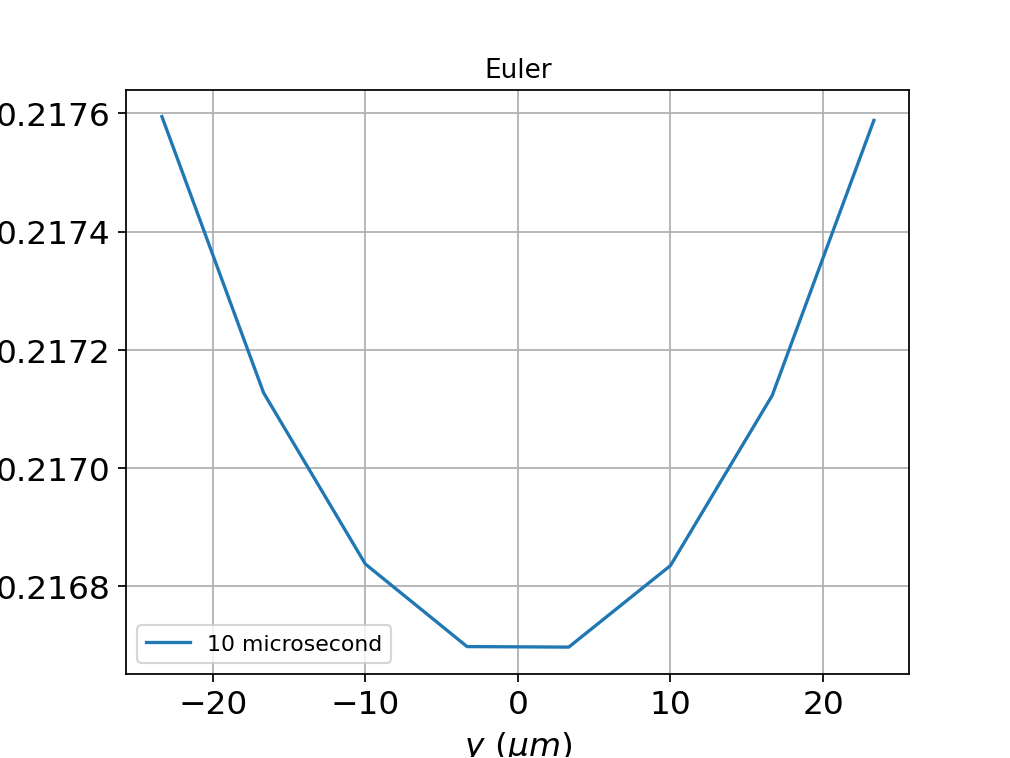

From vapor simulation ... 
c_r = 0.413%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


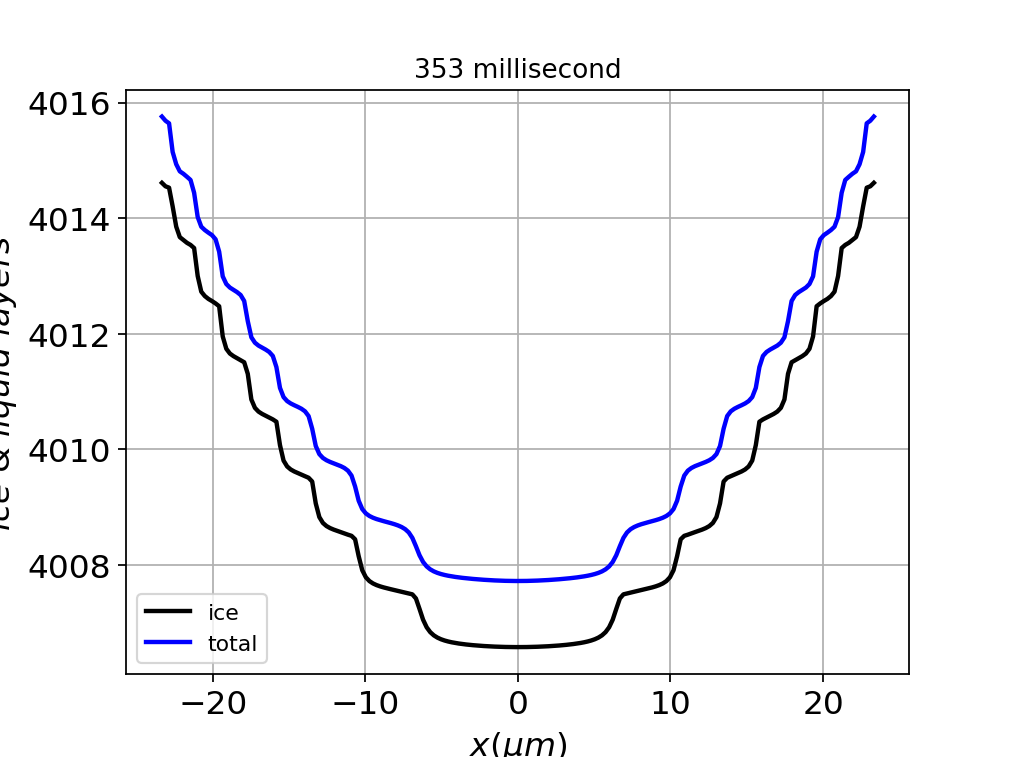

<IPython.core.display.Javascript object>


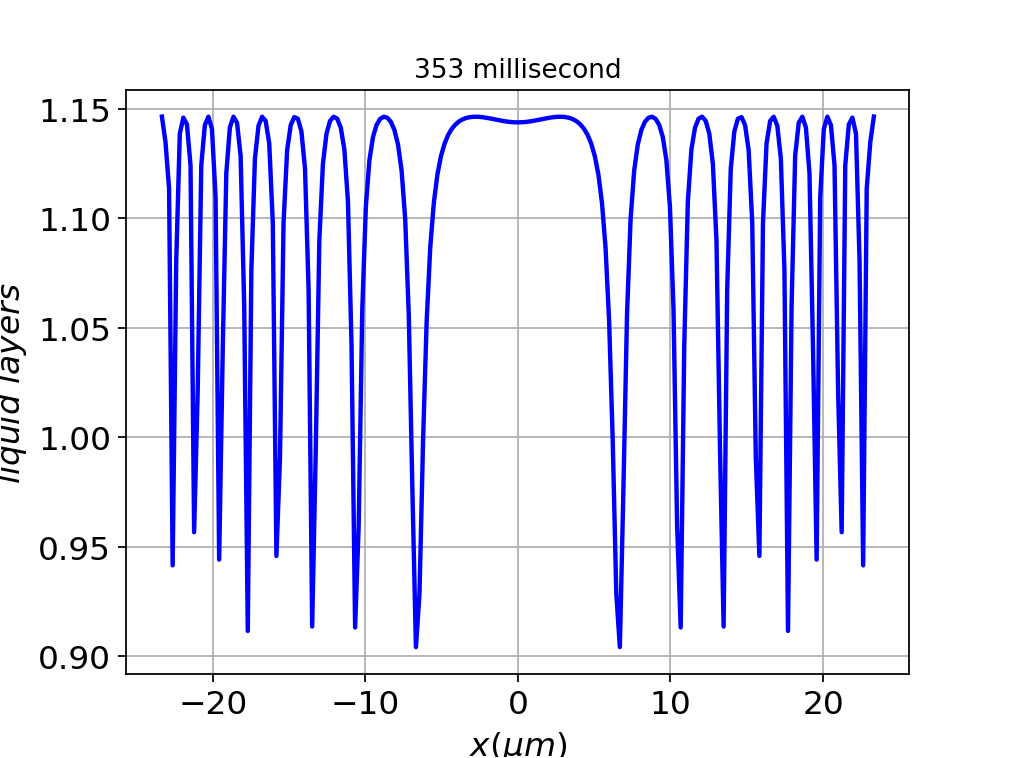

<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  3.6048911184337653 micrometer / second
   from QLC =  3.40606456807145 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>


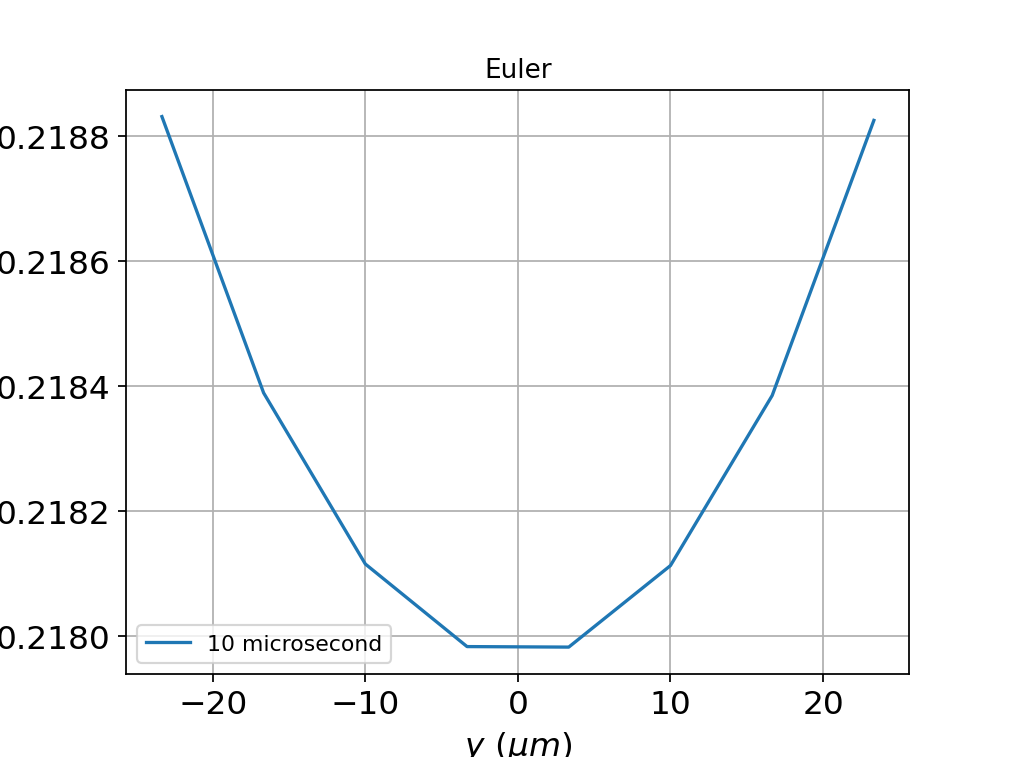

From vapor simulation ... 
c_r = 0.388%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


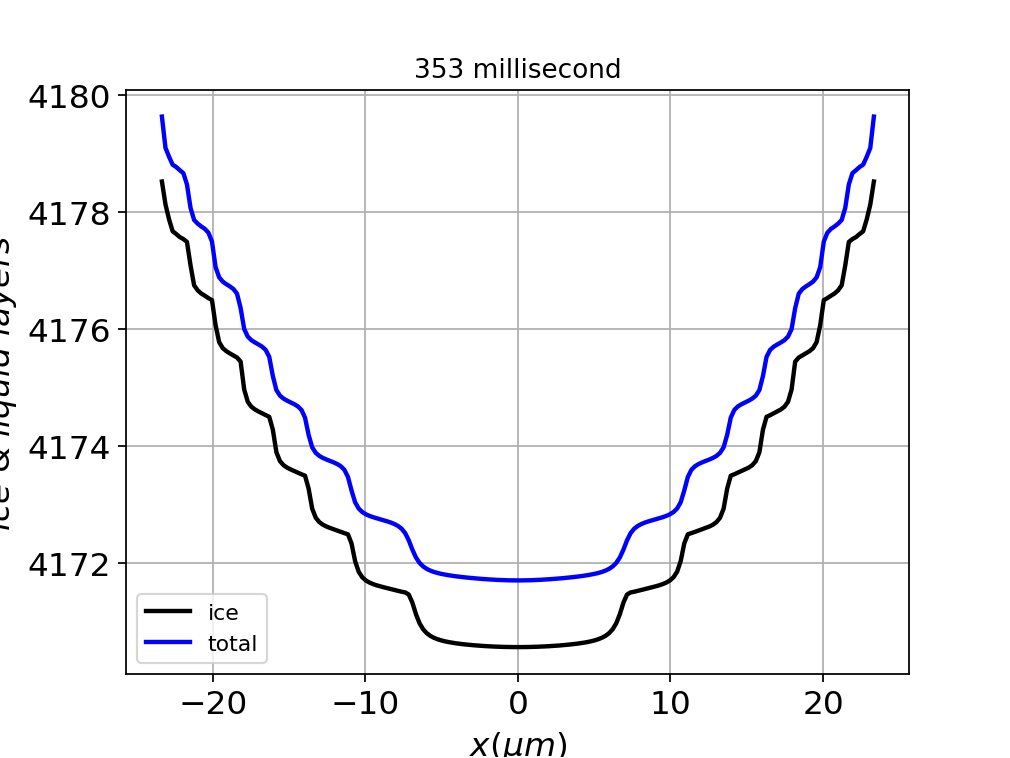

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  3.40606456807145 micrometer / second
   from QLC =  3.5456548651305893 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.405%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


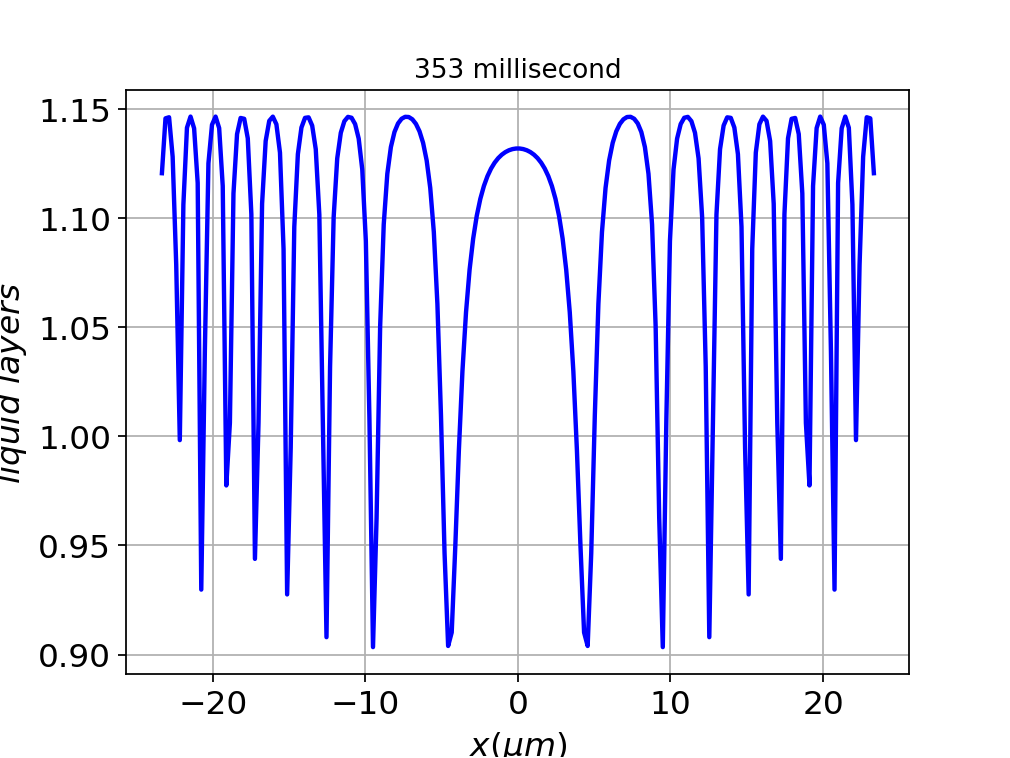

<IPython.core.display.Javascript object>


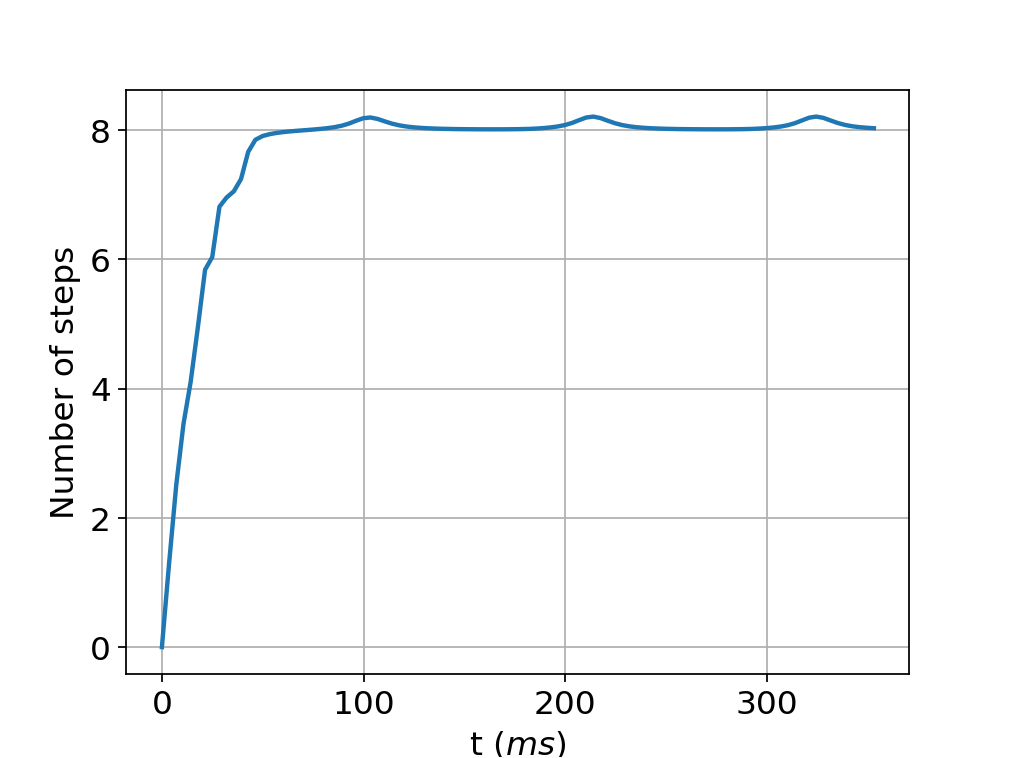

growth rates ... 
   from previous vaporfield =  3.5456548651305893 micrometer / second
   from QLC =  3.447482942602649 micrometer / second
g_ice should be smaller than ...
   sigmaI_far_field x nu_kin =  15.584109480151987 micrometer / second
D0 =  21.893732126411837
    box length (y) =  8
Solving using Euler


<IPython.core.display.Javascript object>

From vapor simulation ... 
c_r = 0.393%
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


<IPython.core.display.Javascript object>


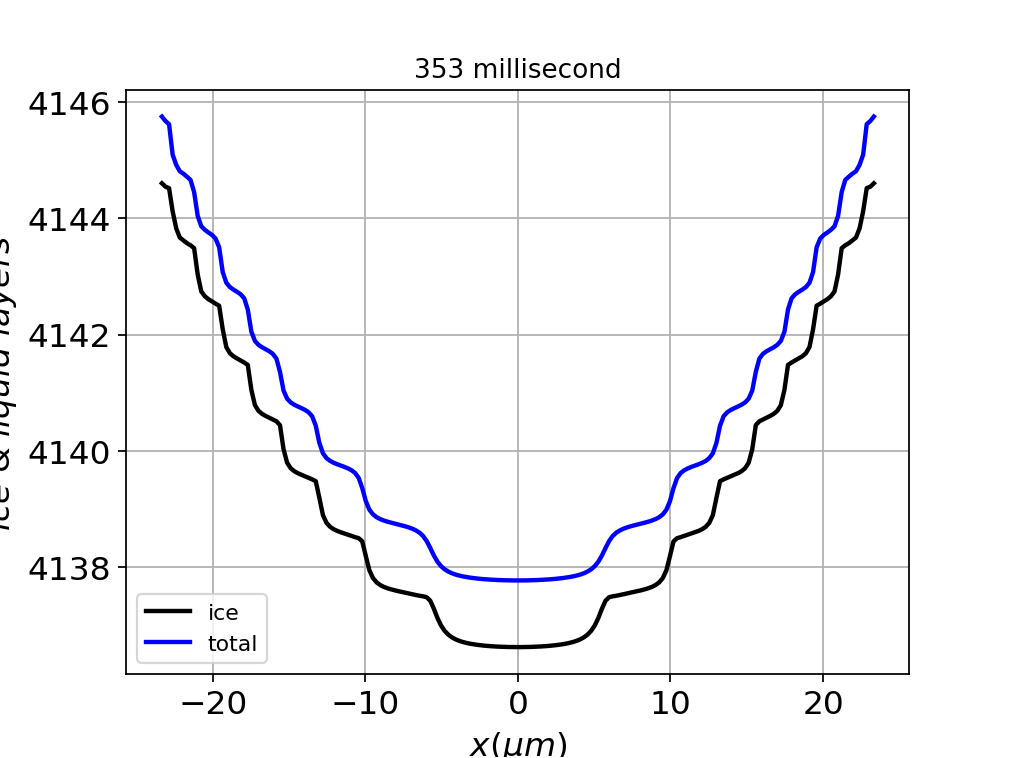

<IPython.core.display.Javascript object>


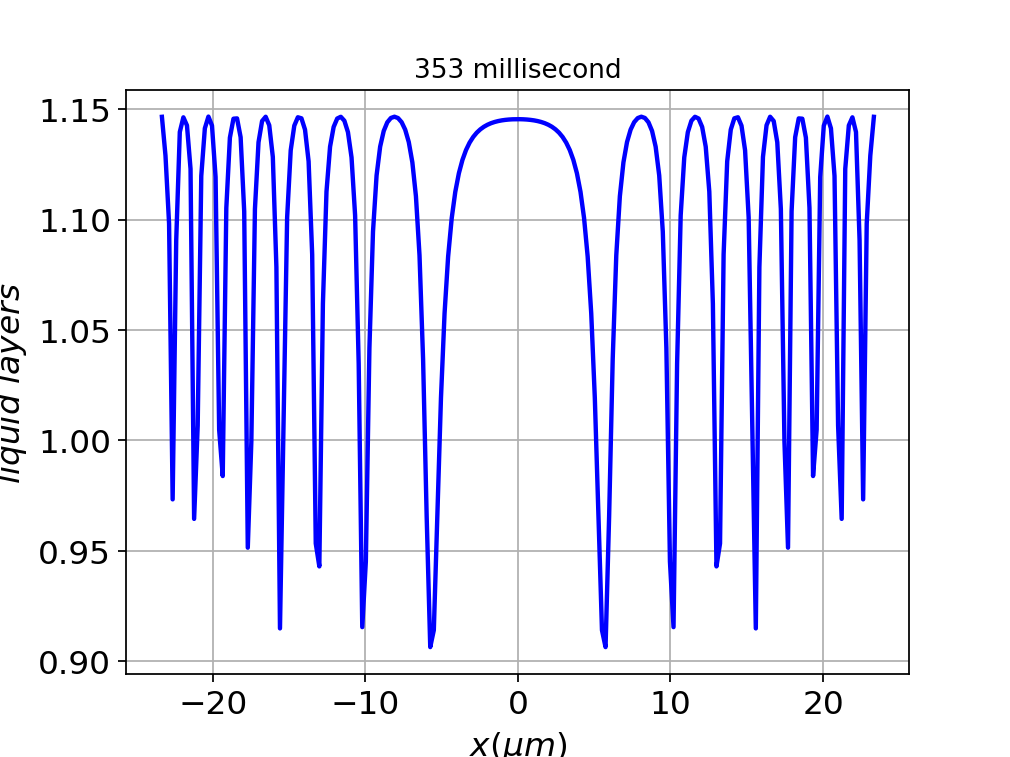

<IPython.core.display.Javascript object>

growth rates ... 
   from previous vaporfield =  3.447482942602649 micrometer / second
   from QLC =  3.5167631533676054 micrometer / second


In [9]:
for i in range(10):
    
    # Update the growth rate from the last QLC run
    g_ice_vapor = g_ice_QLC
    print('g_ice should be smaller than ...')
    print('   sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

    # Call the vaporfield code
    [x_vapor, sigmaIx_vapor], [y_vapor, sigmaIy_vapor] = \
        QLC.VF2d(Temperature,Pressure,g_ice_vapor,sigmaI_far_field,L,\
                 AssignQuantity,verbose=0,Integration_method=Integration_method,tmax=tmax)
    
    # Plot the supersaturation right "above" the surface (i.e., the next y-bin)
    plt.figure()        
    plt.plot(x_vapor.magnitude,sigmaIx_vapor.magnitude,label=str(tmax),ms=markersize)
    plt.xlabel(r'$y$ ($\mu m$)', fontsize=fontsize)
    plt.ylabel(r'$\sigma_I(x)$',fontsize=fontsize)
    plt.title(Integration_method)
    plt.grid(True)
    plt.legend()

    # Use sigmaIx for sigmaI
    sigmaI_QLC = np.interp(x_QLC,x_vapor,sigmaIx_vapor)
    c_r = (np.max(sigmaI_QLC)-np.min(sigmaI_QLC))/np.max(sigmaI_QLC)
    c_r_percent = c_r*100
    print('From vapor simulation ... ')
    print("c_r = " + "{:.3f}".format(c_r_percent.magnitude)+'%')
    
    # But adjusting it because the vaporfield code isn't symmetrical
    alpha = c_r*np.max(sigmaIx_vapor)/x_vapor[-1]**2
    sigmaI_QLC = alpha*x_QLC**2+np.min(sigmaIx_vapor)
    ix_QLC_mid = int(len(x_QLC)/2)
    for i in range(0,ix_QLC_mid):
        sigmaI_QLC[-i-1] = sigmaI_QLC[i]

    # Solve the QLC trajectory with the revised sigmaI
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod='LSODA')
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Report
    g_ice_QLC = QLC.report_growth_results(x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer)
    print('growth rates ... ')
    print('   from previous vaporfield = ',g_ice_vapor)
    print('   from QLC = ',g_ice_QLC)